# Training Famous People Recognition

https://www.kaggle.com/datasets/vasukipatel/face-recognition-dataset/data

In [3]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
csv_path = "data/Dataset.csv"
faces_dir = "data/Faces/Faces"

df = pd.read_csv(csv_path)

In [7]:
test_indices = []
train_indices = []
label_counts = defaultdict(int)

for idx, row in df.iterrows():
    label = row['label']
    if label_counts[label] < 5:
        test_indices.append(idx)
        label_counts[label] += 1
    else:
        train_indices.append(idx)

df_train = df.iloc[train_indices].reset_index(drop=True)
df_test = df.iloc[test_indices].reset_index(drop=True)

In [8]:
all_labels = sorted(df['label'].unique())
label2idx = {label: idx for idx, label in enumerate(all_labels)}
idx2label = {idx: label for label, idx in label2idx.items()}

df_train['label_idx'] = df_train['label'].map(label2idx)
df_test['label_idx'] = df_test['label'].map(label2idx)

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class FaceDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id'])
        image = Image.open(img_path).convert('RGB')
        label = row['label_idx']
        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
train_dataset = FaceDataset(df_train, faces_dir, transform)
test_dataset = FaceDataset(df_test, faces_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# 8. ResNet model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(label2idx))
model = model.to(device)

e:\coffee-maps-survaillance\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\coffee-maps-survaillance\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Omen/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:34<00:00, 2.94MB/s]


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [13]:
for epoch in range(50):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 143.5867
Epoch 2: Loss = 25.0303
Epoch 3: Loss = 5.1001
Epoch 4: Loss = 1.5603
Epoch 5: Loss = 1.4610
Epoch 6: Loss = 1.1460
Epoch 7: Loss = 0.8584
Epoch 8: Loss = 2.1496
Epoch 9: Loss = 2.1686
Epoch 10: Loss = 6.6550
Epoch 11: Loss = 4.6461
Epoch 12: Loss = 1.6831
Epoch 13: Loss = 2.1133
Epoch 14: Loss = 2.7960
Epoch 15: Loss = 0.7900
Epoch 16: Loss = 1.2740
Epoch 17: Loss = 2.4878
Epoch 18: Loss = 0.7671
Epoch 19: Loss = 1.2018
Epoch 20: Loss = 2.4527
Epoch 21: Loss = 2.4374
Epoch 22: Loss = 1.5491
Epoch 23: Loss = 0.4832
Epoch 24: Loss = 0.5977
Epoch 25: Loss = 0.9699
Epoch 26: Loss = 0.5677
Epoch 27: Loss = 0.1867
Epoch 28: Loss = 0.0893
Epoch 29: Loss = 0.1554
Epoch 30: Loss = 0.1461
Epoch 31: Loss = 0.1532
Epoch 32: Loss = 0.1415
Epoch 33: Loss = 0.0782
Epoch 34: Loss = 0.3723
Epoch 35: Loss = 5.7652
Epoch 36: Loss = 7.7835
Epoch 37: Loss = 2.5462
Epoch 38: Loss = 1.5489
Epoch 39: Loss = 0.5933
Epoch 40: Loss = 0.4605
Epoch 41: Loss = 0.5853
Epoch 42: Loss = 0.273

In [15]:
# ---- PLOT ----
plt.figure(figsize=(8,5))
plt.plot(range(1, 50+1), losses, marker='o', linestyle='-', color='royalblue', linewidth=2)
plt.title("Training Loss over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(range(1, num_epochs+1, max(1, num_epochs//10)))
plt.show()

NameError: name 'losses' is not defined

<Figure size 800x500 with 0 Axes>

In [16]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().tolist())
        all_labels_list.extend(labels.cpu().tolist())

print(f"\n🎯 Accuracy on test set: {correct}/{total} = {100 * correct / total:.2f}%")


🎯 Accuracy on test set: 152/155 = 98.06%


In [17]:
# after training
torch.save(model.state_dict(), "resnet_famous_faces.pth")

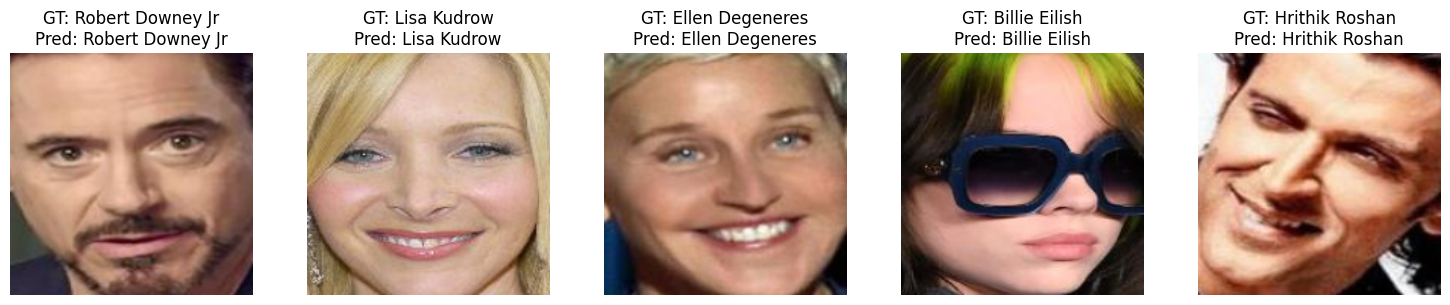

In [18]:
test_images, test_labels = next(iter(DataLoader(test_dataset, batch_size=5)))
test_images = test_images.to(device)

with torch.no_grad():
    test_outputs = model(test_images)
    test_preds = torch.argmax(test_outputs, dim=1)

# Vẽ
plt.figure(figsize=(15, 3))
for i in range(5):
    img = test_images[i].cpu().permute(1, 2, 0).numpy()
    gt = idx2label[test_labels[i].item()]
    pd = idx2label[test_preds[i].item()]
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"GT: {gt}\nPred: {pd}")
    plt.axis("off")
plt.tight_layout()
plt.show()